# **Wildfire Risk Prediction - TD3 Green AI**

**STEP1. Introduction**

The Goal of this notebook is to use the " US Wildfire Dataset (2014–2025)" in order to predict wildfire risk with a binary classification. We are going to use different models: Logistic Regression, Random Forest, XGBoost.

Through this notebok, we will aslo try our best to  mix Green AI aspects and performance(model simplicity, limited use of AI chatboxes). We will also be aligned with the literature we reviewed.



**1-Imports**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (f1_score, precision_score, recall_score,roc_auc_score, average_precision_score)
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

**2-Load the dataset**

In [1]:
import kagglehub
import os
import pandas as pd

# download dataset fro the kaggle path
path = kagglehub.dataset_download("firecastrl/us-wildfire-dataset")
print("Dataset downloaded to:", path)

csv_file = None
for root, dirs, files in os.walk(path):
    for f in files:
        if f.endswith(".csv"):
            csv_file = os.path.join(root, f)
            break
    if csv_file:
        break

print("CSV file found:", csv_file)

df = pd.read_csv(csv_file)
df.head()

Dataset downloaded to: C:\Users\estel\.cache\kagglehub\datasets\firecastrl\us-wildfire-dataset\versions\1
CSV file found: C:\Users\estel\.cache\kagglehub\datasets\firecastrl\us-wildfire-dataset\versions\1\Wildfire_Dataset.csv


,latitude,longitude,datetime,Wildfire,pr,rmax,rmin,sph,srad,tmmn,tmmx,vs,bi,fm100,fm1000,erc,etr,pet,vpd
0,48.128431,-97.276685,2018-08-15,No,0.0,78.6,14.9,0.00582,272.6,282.0,301.6,3.0,40.0,10.2,12.2,54.0,7.5,5.5,1.59
1,48.128431,-97.276685,2018-08-16,No,0.0,80.4,13.9,0.00676,264.0,283.9,304.9,3.0,40.0,9.7,12.0,56.0,8.2,5.9,1.93
2,48.128431,-97.276685,2018-08-17,No,0.0,70.9,20.4,0.00672,265.6,285.8,300.7,3.1,40.0,9.2,11.9,56.0,7.2,5.3,1.51
3,48.128431,-97.276685,2018-08-18,No,5.0,65.2,19.4,0.00756,261.4,289.0,303.3,5.1,0.0,9.9,12.0,40.0,10.0,6.9,1.85
4,48.128431,-97.276685,2018-08-19,No,0.0,100.0,42.2,0.00895,166.8,283.8,296.5,4.7,41.0,11.8,12.1,47.0,4.6,3.4,0.66


In [6]:
df.columns

Index(['latitude', 'longitude', 'datetime', 'Wildfire', 'pr', 'rmax', 'rmin',
       'sph', 'srad', 'tmmn', 'tmmx', 'vs', 'bi', 'fm100', 'fm1000', 'erc',
       'etr', 'pet', 'vpd'],
      dtype='object')

**3-Preprocessing**

- General informations about the dataset

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9509925 entries, 0 to 9509924
Data columns (total 19 columns):
 #   Column     Dtype  
---  ------     -----  
 0   latitude   float64
 1   longitude  float64
 2   datetime   object 
 3   Wildfire   object 
 4   pr         float64
 5   rmax       float64
 6   rmin       float64
 7   sph        float64
 8   srad       float64
 9   tmmn       float64
 10  tmmx       float64
 11  vs         float64
 12  bi         float64
 13  fm100      float64
 14  fm1000     float64
 15  erc        float64
 16  etr        float64
 17  pet        float64
 18  vpd        float64
dtypes: float64(17), object(2)
memory usage: 1.3+ GB


- Check duplicates

In [13]:
# Check duplicates
num_duplicates = df.duplicated().sum()
print("Number of duplicated rows:", num_duplicates)
display(df[df.duplicated()].head())


Number of duplicated rows: 13920


,latitude,longitude,datetime,Wildfire,pr,rmax,rmin,sph,srad,tmmn,tmmx,vs,bi,fm100,fm1000,erc,etr,pet,vpd
155775,33.90551,-118.1835,2020-11-09,No,0.0,80.9,35.9,0.00471,184.3,279.5,289.2,2.1,28.0,15.6,14.4,39.0,2.9,2.1,0.63
155776,33.90551,-118.1835,2020-11-10,No,0.0,74.3,27.7,0.00457,182.5,280.4,291.9,1.9,29.0,14.1,14.3,42.0,3.2,2.3,0.85
155777,33.90551,-118.1835,2020-11-11,No,0.0,84.5,34.1,0.00536,180.3,280.7,291.9,1.5,27.0,13.9,14.3,41.0,2.6,2.0,0.73
155778,33.90551,-118.1835,2020-11-12,No,0.0,97.7,38.1,0.00652,165.1,281.3,293.6,1.2,24.0,15.1,14.6,38.0,2.3,1.8,0.69
155779,33.90551,-118.1835,2020-11-13,No,0.0,95.9,44.8,0.00670,165.5,282.0,291.9,1.6,25.0,15.9,14.6,36.0,2.3,1.8,0.56


In [15]:
#  drop the duplicated rows
df = df.drop_duplicates()

- Detect anormal values (32767)

During the visualisation step, we noticed that some meteorological variables contain the value 32767.
This number is not physically possible (32767°C temperature, humidity 32767%, etc...).  
After checking documentation, 32767 is a placeholder for missing or invalid data in several climate datasets.

So these values must be treated as missing values, not real measurements.


In [21]:
mask_32767 = (df == 32767.0)
count_32767 = mask_32767.sum().sum()

print("Total number of 32767.0 values:", count_32767)


Total number of 32767.0 values: 385875


we delete all the rows containing at least one 32767 value

In [24]:
df = df[~mask_32767.any(axis=1)]

- Convert "datetime" to real datetime

In [26]:
# Check a few datetime samples
print(df["datetime"].head())

0    2018-08-15
1    2018-08-16
2    2018-08-17
3    2018-08-18
4    2018-08-19
Name: datetime, dtype: object


In [31]:
df["datetime"] = pd.to_datetime(df["datetime"], errors='coerce')

print("Number of not a time value values after datetime conversion:",
      df["datetime"].isna().sum())

Number of not a time value values after datetime conversion: 0


- Detect unrealistic values (verry high value or neagtive values)

In [33]:
num_cols = df.select_dtypes(include=['float64','int64']).columns

for col in num_cols:
    print(col, "| min:", df[col].min(), "| max:", df[col].max())

latitude | min: 25.2602699992712 | max: 48.9987299990662
longitude | min: -124.437 | max: -67.0125
pr | min: 0.0 | max: 528.0
rmax | min: 5.0 | max: 100.0
rmin | min: 1.0 | max: 100.0
sph | min: 0.00013 | max: 0.02413
srad | min: 0.0 | max: 440.6
tmmn | min: 230.9 | max: 310.0
tmmx | min: 241.9 | max: 324.3
vs | min: 0.3 | max: 19.6
bi | min: 0.0 | max: 189.0
fm100 | min: 1.1 | max: 32.6
fm1000 | min: 2.1 | max: 42.8
erc | min: 0.0 | max: 121.0
etr | min: 0.0 | max: 26.5
pet | min: 0.0 | max: 16.9
vpd | min: 0.0 | max: 8.1


The dataset contains consistent and realistic values for each meteorological
variable.

- Checking missing values

In [37]:
print(df.isna().sum())

latitude     0
longitude    0
datetime     0
Wildfire     0
pr           0
rmax         0
rmin         0
sph          0
srad         0
tmmn         0
tmmx         0
vs           0
bi           0
fm100        0
fm1000       0
erc          0
etr          0
pet          0
vpd          0
dtype: int64


There is no missing values so we do not have to delete rows or change them.

**4-Visualizations**

- Target distribution

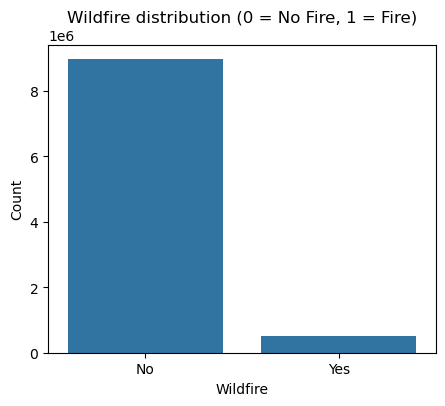

In [42]:
plt.figure(figsize=(5, 4))
sns.countplot(x=df["Wildfire"])
plt.title("Wildfire distribution (0 = No Fire, 1 = Fire)")
plt.xlabel("Wildfire")
plt.ylabel("Count")
plt.show()


The dataset is verry imbalanced. The vast majority of records correspond to "no fire". The class that interests us is "yes" and is verry low coparing to the "No" class. We must be careful because a model could achieve high accuracy bit because the dataset is imabalnced, it would be a fake or artificial accurary; we must pay attention to some evaluation metrucs (F1 score, PR-AUC) which take into accoount minority classes. We must also apply class balancing techniques during th emodel training.




- Correlation Matrix

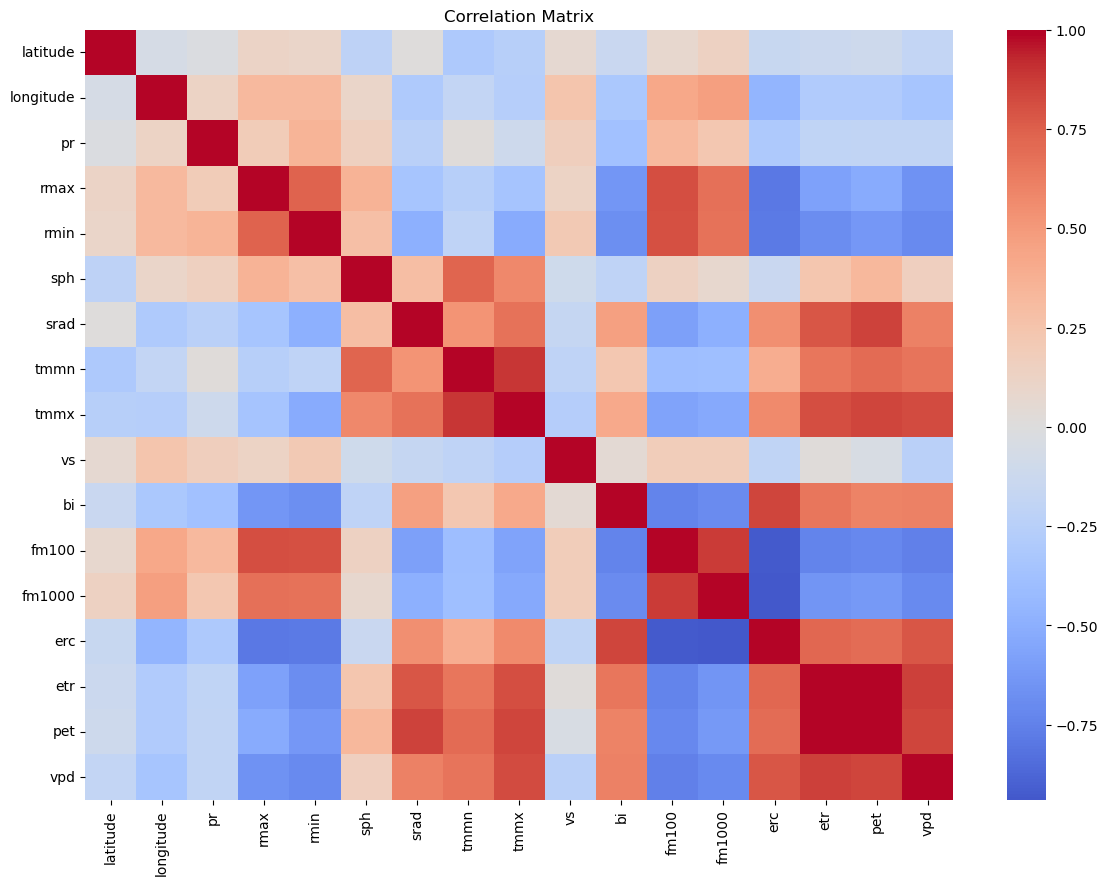

In [46]:
plt.figure(figsize=(14, 10))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()


This heatmap displays the Pearson correlation coefficients between the features, where dark red indicates a strong positive correlation and dark blue indicates a strong negative correlation. So, it reveals multiple collinearity within the dataset, highlighting a cluster of 'hot and dry' variables (such as vpd, pet, etr, and tmmx) that are strongly positively correlated with each other and negatively correlated with fuel moisture indicators. This redundancy indicates that several features are communicating simiilar information regarding fire risk conditions.

- Distribution of meteorological variables

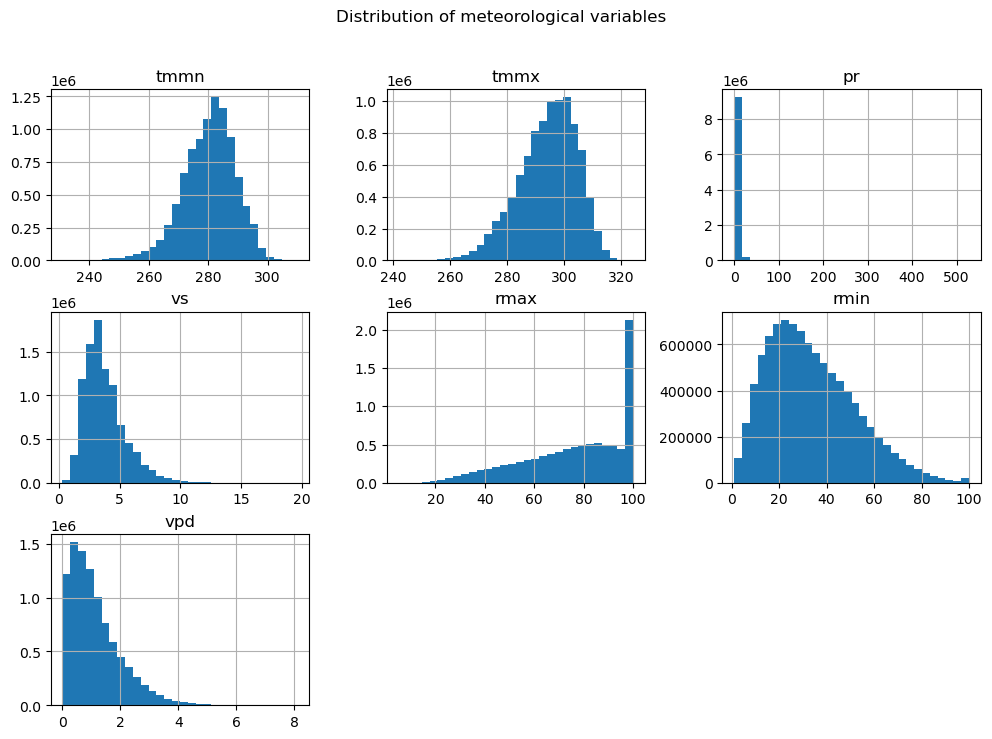

In [49]:
cols = ["tmmn", "tmmx", "pr", "vs", "rmax", "rmin", "vpd"]

df[cols].hist(figsize=(12, 8), bins=30)
plt.suptitle("Distribution of meteorological variables")
plt.show()


- Geographical Distribution of Samples

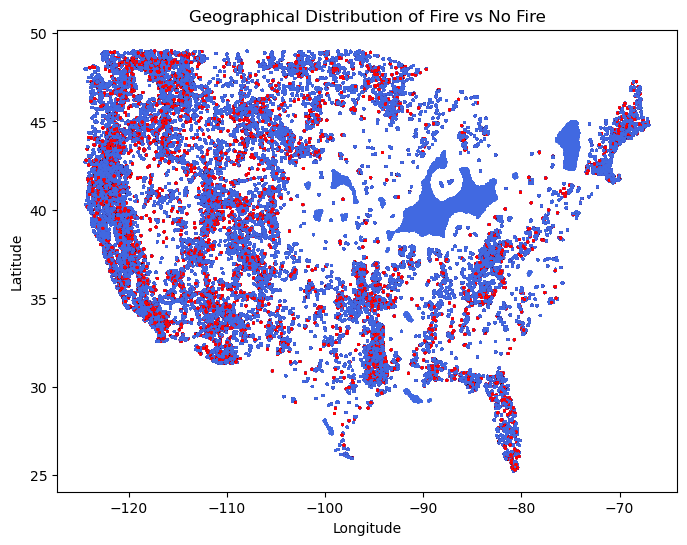

In [51]:
plt.figure(figsize=(8, 6))

colors = df["Wildfire"].map({"No": "royalblue", "Yes": "red"})

plt.scatter(df["longitude"],df["latitude"],c=colors,s=1,alpha=0.5)

plt.title("Geographical Distribution of Fire vs No Fire")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

This scatter plot visualizes the spatial distribution of the dataset across the contiguous United States, using latitude and longitude as coordinate features. It distinguishes between the binary target classes, with red points representing wildfire occurrences and blue points indicating non-fire observations, highlighting specific geographical clusters that may assist the model in learning regional risk patterns. There are far more blue dots than red dots : this represents well the class imbalance that we spot earlier.

- How weather differs for fire vs No fire



In [53]:
# We take a sample beause our dataset is too big and take a lot of time to compute
df_vis = df.sample(n=min(1_000_000, len(df)), random_state=42)

print(df_vis.shape)


(1000000, 19)


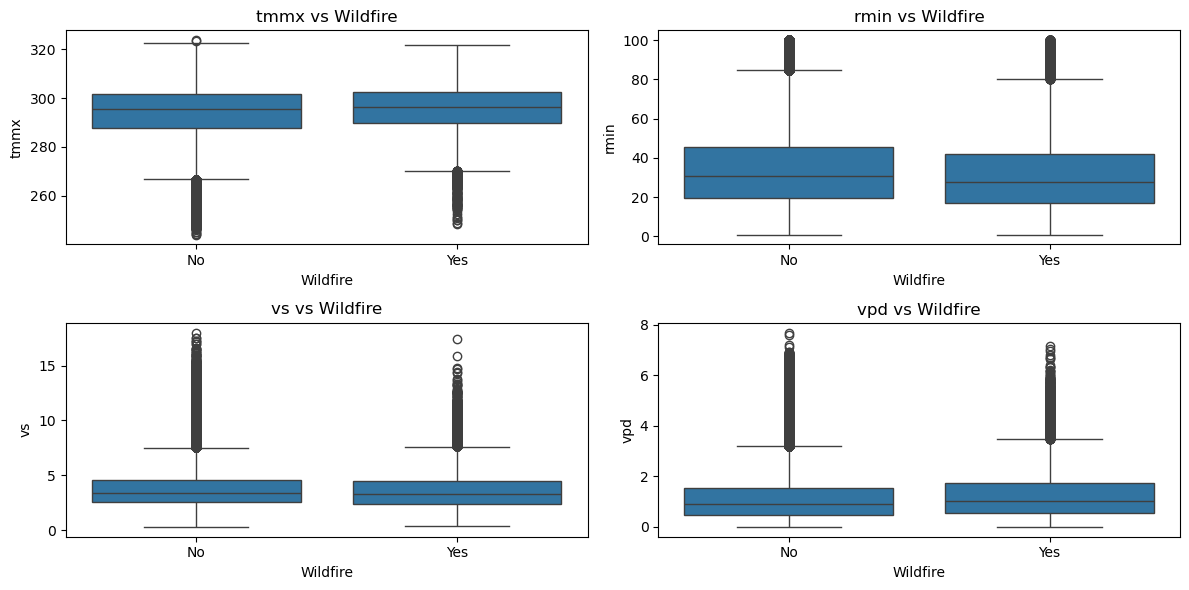

In [55]:
features_box = ["tmmx", "rmin", "vs", "vpd"]

plt.figure(figsize=(12,6))
for i, col in enumerate(features_box, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df_vis["Wildfire"], y=df_vis[col])
    plt.title(f"{col} vs Wildfire")
plt.tight_layout()
plt.show()


- Key environmental relationships

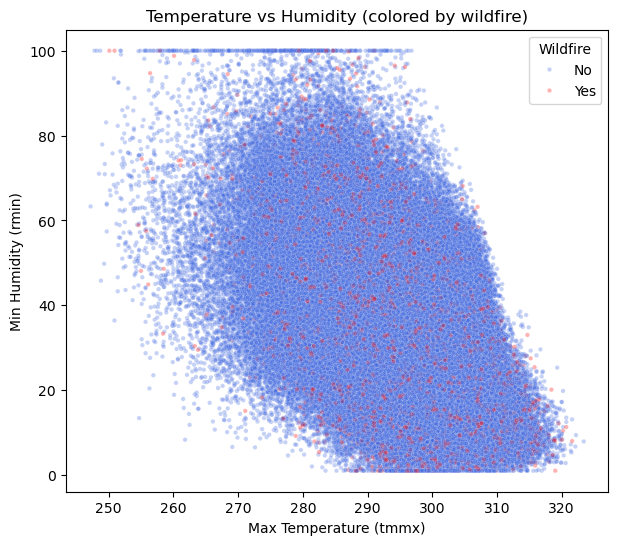

In [58]:
plt.figure(figsize=(7,6))

sns.scatterplot(
    data = df_vis.sample(200_000),
    x = "tmmx",
    y = "rmin",
    hue = "Wildfire",
    palette = {"No": "royalblue", "Yes": "red"},  # corresponds to real values
    alpha = 0.3,
    s = 10
)

plt.title("Temperature vs Humidity (colored by wildfire)")
plt.xlabel("Max Temperature (tmmx)")
plt.ylabel("Min Humidity (rmin)")
plt.show()



- Pairplot

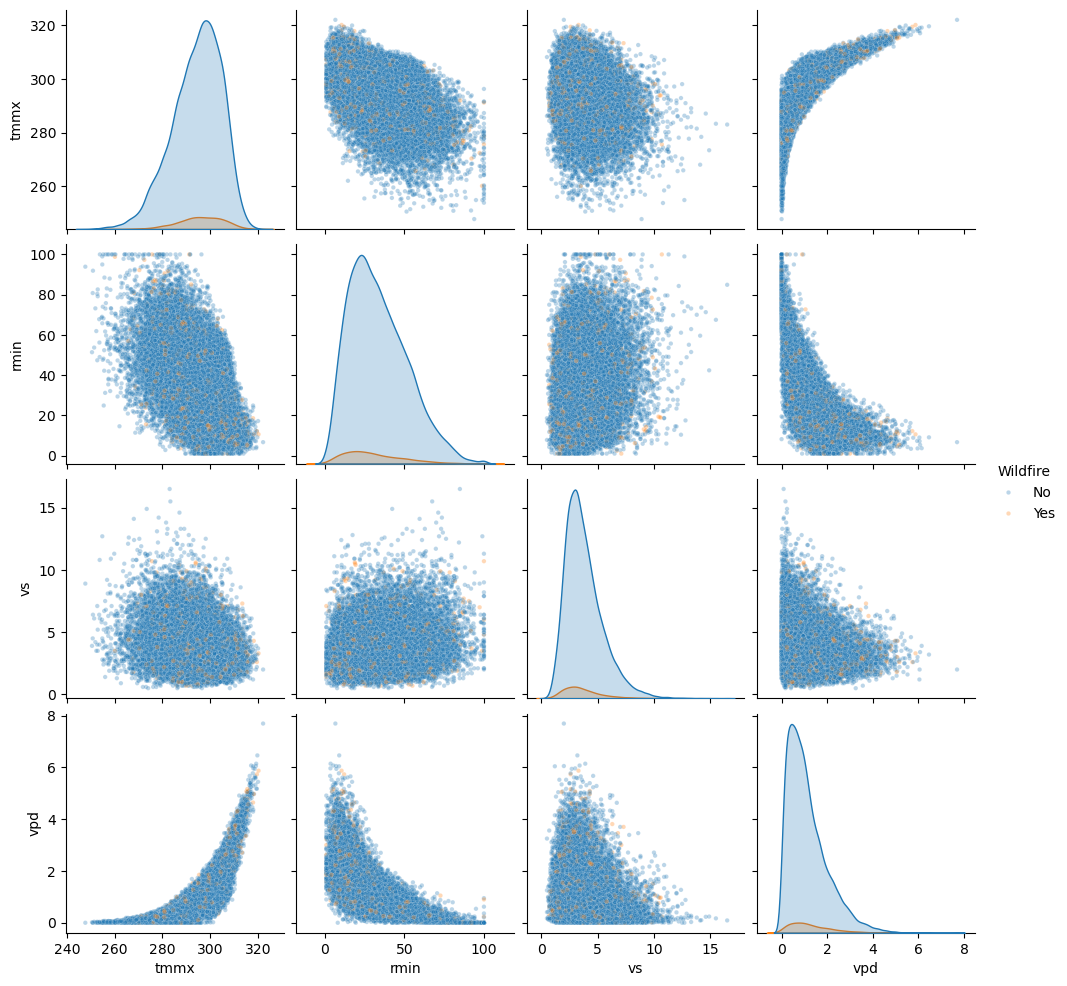

In [62]:
pair_df = df_vis.sample(30_000)

sns.pairplot(pair_df[["tmmx", "rmin", "vs", "vpd", "Wildfire"]],
    hue="Wildfire",
    plot_kws=dict(alpha=0.3, s=10),
    diag_kind="kde"
)
plt.show()


**Model implementation**

- Stratification

In [66]:
sample_size = 500_000 #we keep only 500 000 values because the dataset is too big

df_sample, _ = train_test_split(df,train_size=sample_size,stratify=df["Wildfire"],random_state=42)

print("Sample size:", len(df_sample))
print("\nProportion in sample:")
print(df_sample["Wildfire"].value_counts(normalize=True))

Sample size: 500000

Proportion in sample:
Wildfire
No     0.947094
Yes    0.052906
Name: proportion, dtype: float64


Prepare X and Y

In [69]:
feature_cols = ['pr','rmax','rmin','sph','srad','tmmn','tmmx','vs','bi',
                'fm100','fm1000','erc','etr','pet','vpd']

X = df_sample[feature_cols].values
y = df_sample["Wildfire"].values
print(df_sample.isna().sum())

latitude     0
longitude    0
datetime     0
Wildfire     0
pr           0
rmax         0
rmin         0
sph          0
srad         0
tmmn         0
tmmx         0
vs           0
bi           0
fm100        0
fm1000       0
erc          0
etr          0
pet          0
vpd          0
dtype: int64


- Train/ Test

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])

print("\nProportion in TRAIN:")
print(pd.Series(y_train).value_counts(normalize=True))

print("\nProportion in TEST:")
print(pd.Series(y_test).value_counts(normalize=True))


Train size: 400000
Test size : 100000

Proportion in TRAIN:
No     0.947095
Yes    0.052905
Name: proportion, dtype: float64

Proportion in TEST:
No     0.94709
Yes    0.05291
Name: proportion, dtype: float64


- Model

We do a features scaling for the model that need it

In [76]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Logistic Regression**

We will implement first logistic regression then compare with another model to see which is better. We chose logistic regression first because it is simple and esay to interpret (also a very known model).

In [83]:
log_reg = LogisticRegression(max_iter=500, class_weight="balanced")

log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)

print("\nLogistic Regression Results")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Results
              precision    recall  f1-score   support

          No       0.96      0.57      0.71     94709
         Yes       0.07      0.60      0.13      5291

    accuracy                           0.57    100000
   macro avg       0.52      0.58      0.42    100000
weighted avg       0.91      0.57      0.68    100000



**Random Forest**

Now we will test with random forest (another classification model based on tree decision, it is more powerful, robust and handles non-linearities)

In [86]:
# random forest model
rf = RandomForestClassifier(n_estimators=120, max_depth=12, class_weight="balanced", random_state=42)
# choice of n_estimators=120 : not too large (energy efficient)
# max_depth=12 to limit depth to reduce computation

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\nRandom Forest Results")
print(classification_report(y_test, y_pred_rf))


Random Forest Results
              precision    recall  f1-score   support

          No       0.96      0.70      0.81     94709
         Yes       0.08      0.47      0.14      5291

    accuracy                           0.69    100000
   macro avg       0.52      0.58      0.47    100000
weighted avg       0.91      0.69      0.77    100000



Both models struggle to provide actionable fire predictions due to the severe class imbalance. They correctly detect many true fire cases, but at the cost of a very high false-alarm rate. This indicates that simple classifiers are insufficient, and improvements such as probability threshold tuning, deeper tree models, and advanced algorithms (like XGBoost) are required to achieve meaningful wildfire prediction performance. We could also try a Deep Learning models approach as it is what's commonly used nowadays for this type of prediction.

In [130]:
from sklearn.metrics import accuracy_score

acc_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", acc_lr)

acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", acc_rf)

Logistic Regression Accuracy: 0.56859
Random Forest Accuracy: 0.68571


**Future implementation : we could try XGBoost**